# PREDICT CUSTOMER CHURN FOR A TELECOM COMPANY IN CA

## Table of Contents
1. [Define Project](#1.-Define-Project)
2. [Data Exploration](#2.-Data-Exploration)

3. [Data Processing and develop machine model](#3.-Data-Processing-and-develop-machine-model)\
    3.1. [Logistic Regression](#3.1.-Logistic-Regression)\
    3.2. [Naive Bayes](#3.2.-Naive-Bayes)\
    3.3. [Decision Tree](#3.3.-Decision-Tree)\
    3.4. [Random Forest](#3.4.-Random-Forest)

4. [Conclusion](#4.-Conclusion)

# 1. Define Project

Given the importance of customer churn, telecom companies are working hard to survive in this competitive industry. Therefore, finding the main factor that increases customer churn is important to take the initiative to bring down this churn. I collected a dataset on Kaggle including 41 attributes and 7043 instances, each instance shows the record of a customer and their status (stayed, churned, joined) with the company. In this project, I attempted to achieve two main objectives: 

1/ Identify and analyze most relevant attributes that cause customer churn \
2/ Predict a potential churn and make recommendations to prevent it

In this project, I will develop different models including logistic regression, Naive Bayes, decision trees and Random Forests to predict customer churn. By comparing the accuracy of the prediction result, I can determine which model is the best.

Import neccessary packages in the project

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, cross_val_predict, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
import numpy as np
from scipy.stats import pearsonr
from sklearn import preprocessing, metrics
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as sm

# 2. Data Exploration

Import the dataset

In [2]:
telecom_customer_churn = pd.read_csv('telecom_customer_churn.csv')
churn_df = telecom_customer_churn.copy(deep=True)
print(churn_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Married                            7043 non-null   object 
 4   Number of Dependents               7043 non-null   int64  
 5   City                               7043 non-null   object 
 6   Zip Code                           7043 non-null   int64  
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Number of Referrals                7043 non-null   int64  
 10  Tenure in Months                   7043 non-null   int64  
 11  Offer                              7043 non-null   objec

Check unique value of each variable to see if their types are reasonable. It is determine the quality of data and see if we need to change data type or not.

In [7]:
def data_type_check(df):
    print("data shape: ", df.shape)
    df_info = pd.DataFrame({'% Missing value': round(df.isna().sum()/len(df)*100,2),
                            '% Duplicated value': round(df.duplicated().sum()/len(df)*100,2),
                            'Dtype': df.dtypes,
                            'No unique values': df.nunique(),
                            'Unique values':"",})
    for index in df_info.index:
        if df_info.loc[index,'No unique values'] <= 10:
            df_info.loc[index,'Unique values'] = str(df[index].unique())
        else:
            df_info.loc[index,'Unique values'] = 'Many unique values'
    
    df_stat = df.describe().T[['count','mean','std','min','25%','50%','75%','max']]
    
    df_combined = pd.merge(df_info,df_stat,how="left",left_index=True,right_index=True)
    
    return df_combined

In [8]:
data_type_check(churn_df)

data shape:  (7043, 38)


% Missing value  % Duplicated value  \
Customer ID                                   0.00                 0.0   
Gender                                        0.00                 0.0   
Age                                           0.00                 0.0   
Married                                       0.00                 0.0   
Number of Dependents                          0.00                 0.0   
City                                          0.00                 0.0   
Zip Code                                      0.00                 0.0   
Latitude                                      0.00                 0.0   
Longitude                                     0.00                 0.0   
Number of Referrals                           0.00                 0.0   
Tenure in Months                              0.00                 0.0   
Offer                                         0.00                 0.0   
Phone Service                                 0.00                 0.0   
Avg Monthly Long Distance Charges             9.68                 0.0   
Multiple Lines                                9.68                 0.0   
Internet Service                              0.00                 0.0   
Internet Type                                21.67                 0.0   
Avg Monthly GB Download                      21.67                 0.0   
Online Security                              21.67                 0.0   
Online Backup                                21.67                 0.0   
Device Protection Plan                       21.67                 0.0   
Premium Tech Support                         21.67                 0.0   
Streaming TV                                 21.67                 0.0   
Streaming Movies                             21.67                 0.0   
Streaming Music                              21.67                 0.0   
Unlimited Data                               21.67                 0.0   
Contract                                      0.00                 0.0   
Paperless Billing                             0.00                 0.0   
Payment Method                                0.00                 0.0   
Monthly Charge                                0.00                 0.0   
Total Charges                                 0.00                 0.0   
Total Refunds                                 0.00                 0.0   
Total Extra Data Charges                      0.00                 0.0   
Total Long Distance Charges                   0.00                 0.0   
Total Revenue                                 0.00                 0.0   
Customer Status                               0.00                 0.0   
Churn Category                               73.46                 0.0   
Churn Reason                                 73.46                 0.0   

                                     Dtype  No unique values  \
Customer ID                         object              7043   
Gender                              object                 2   
Age                                  int64                62   
Married                             object                 2   
Number of Dependents                 int64                10   
City                                object              1106   
Zip Code                             int64              1626   
Latitude                           float64              1626   
Longitude                          float64              1625   
Number of Referrals                  int64                12   
Tenure in Months                     int64                72   
Offer                               object                 6   
Phone Service                       object                 2   
Avg Monthly Long Distance Charges  float64              3583   
Multiple Lines                      object                 2   
Internet Service                    object                 2   
Internet Type                       object                 3

Check missing values, duplicated values

In [7]:
# Identify column with missing values
col_has_na = list(df_churn_info['Missing Value'][df_churn_info['Missing Value']>0].index)
col_has_na

['Avg Monthly Long Distance Charges',
 'Multiple Lines',
 'Internet Type',
 'Avg Monthly GB Download',
 'Online Security',
 'Online Backup',
 'Device Protection Plan',
 'Premium Tech Support',
 'Streaming TV',
 'Streaming Movies',
 'Streaming Music',
 'Unlimited Data',
 'Churn Category',
 'Churn Reason']

<AxesSubplot:>

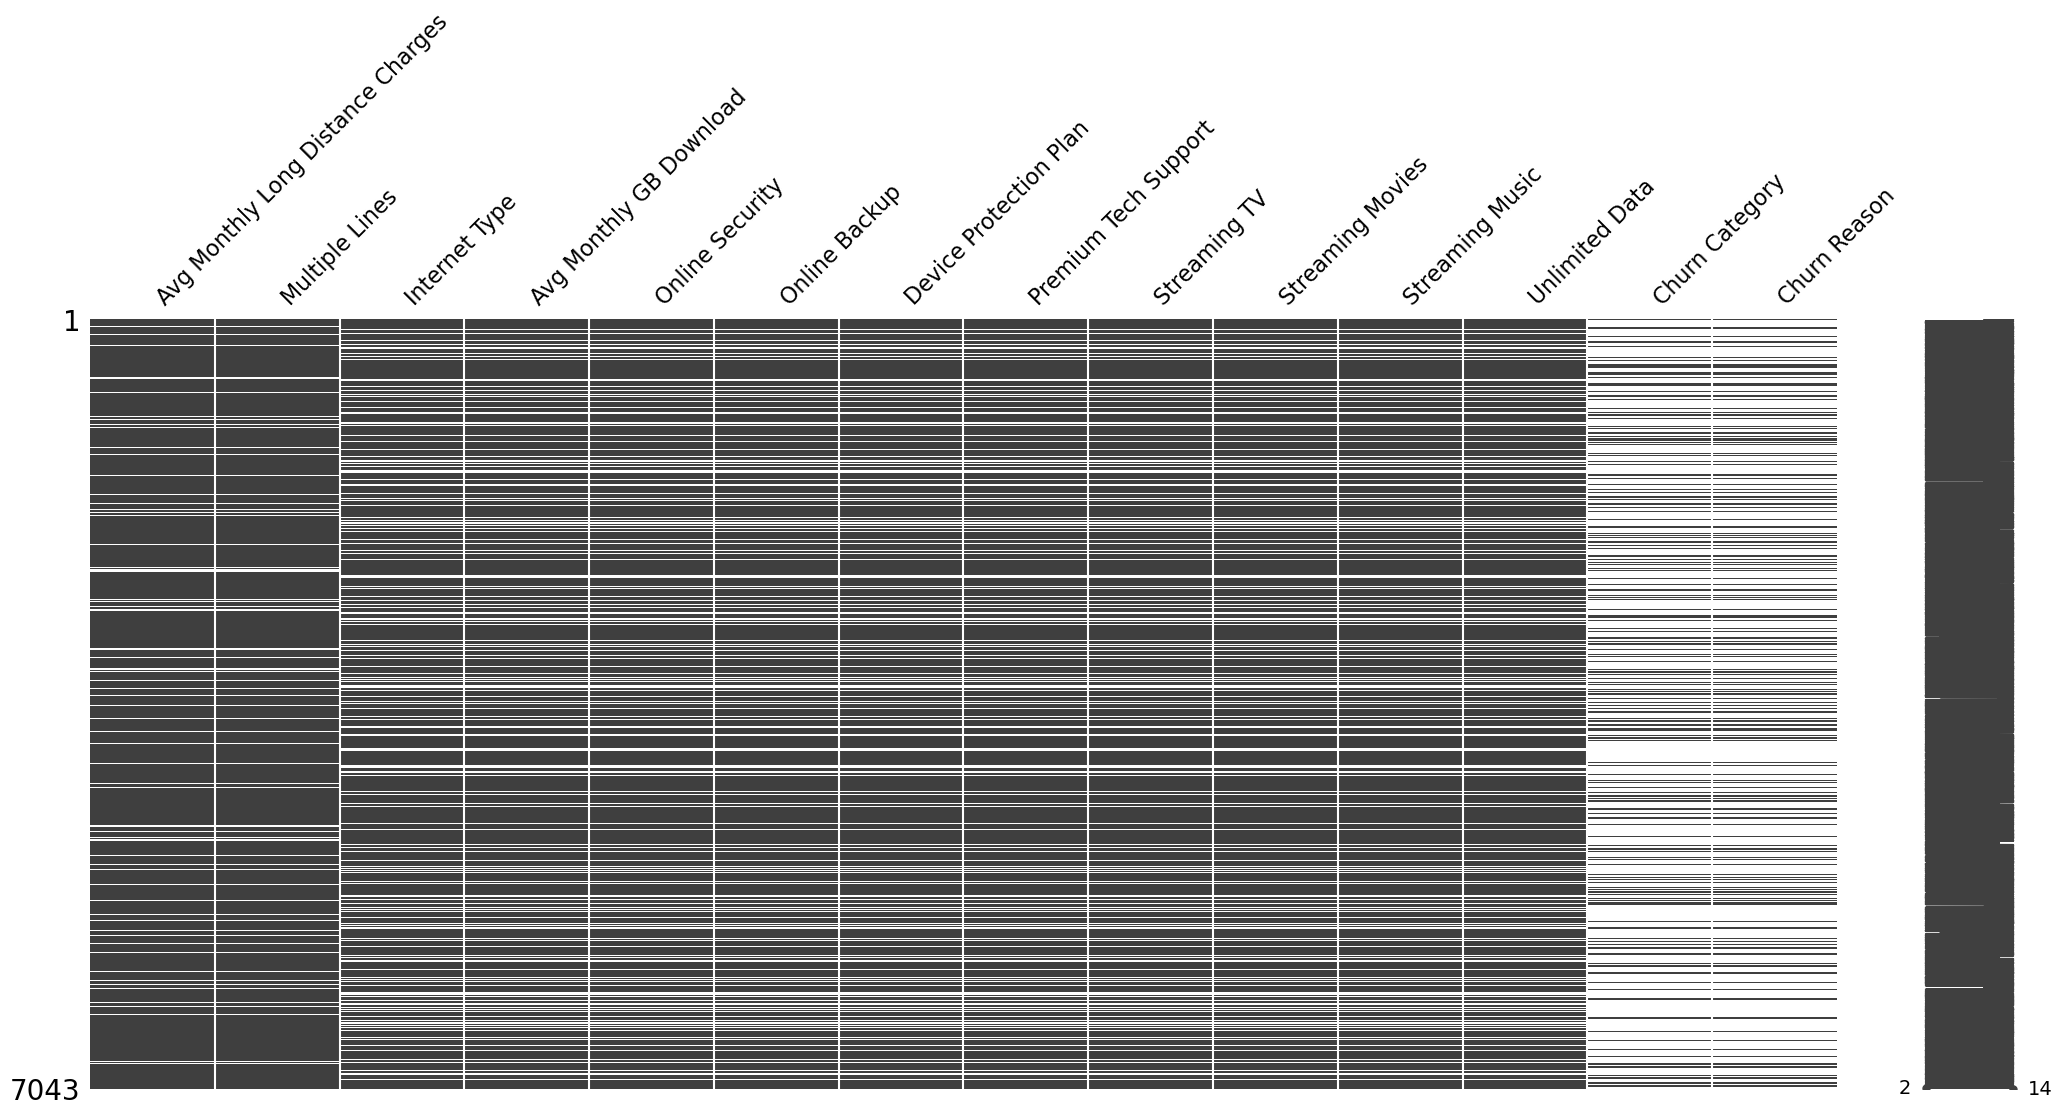

In [8]:
#!pip install missingno
# Import package to visualize the missing values
import missingno as msno
msno.matrix(churn_df[col_has_na])

Analysis:
* Data has 7043 rows and 38 columns with different data types including object, int64, float64.
* All object type columns are categorical, in which several variables are binary.
* Data types fit with their associated value, so we don't need to make a data type adjustment.
* There are several missing values in different columns. Looking at the missing visualization chart, we can see that they occur on same row, which make me believe that they are missing data entry values. The column "Churn Category" and "Churn reason" are not used and will be removed. Then I will remove rows with missing values in other columns in next step.

I will then remove columns that I don't use and rows with missing values before further visualization and analysis

In [9]:
# Drop unused columns
churn_df_pre_process = churn_df.drop(['Customer ID','Churn Category','Churn Reason','City','Zip Code','Latitude','Longitude'],axis=1)
churn_df_pre_process.columns

Index(['Gender', 'Age', 'Married', 'Number of Dependents',
       'Number of Referrals', 'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Customer Status'],
      dtype='object')

Regarding missing values, I can make assumption to fill data with mean, median, or most frequent values. However, after checking row with missing values, I believe believe data entry was missed and hence decided to remove them.

In [10]:
col_has_na_pre_process = [col for col in churn_df_pre_process.columns if churn_df_pre_process[col].isna().sum()>0]
col_has_na_pre_process

['Avg Monthly Long Distance Charges',
 'Multiple Lines',
 'Internet Type',
 'Avg Monthly GB Download',
 'Online Security',
 'Online Backup',
 'Device Protection Plan',
 'Premium Tech Support',
 'Streaming TV',
 'Streaming Movies',
 'Streaming Music',
 'Unlimited Data']

In [11]:
# Remove all row that has na values. At the stage, churn_final_df is the final datasets we can use.
churn_final_df = churn_df_pre_process.dropna(axis=0,how='any',subset=col_has_na_pre_process)
print(churn_final_df.shape)
churn_final_df.isna().sum()

(4835, 31)


Gender                               0
Age                                  0
Married                              0
Number of Dependents                 0
Number of Referrals                  0
Tenure in Months                     0
Offer                                0
Phone Service                        0
Avg Monthly Long Distance Charges    0
Multiple Lines                       0
Internet Service                     0
Internet Type                        0
Avg Monthly GB Download              0
Online Security                      0
Online Backup                        0
Device Protection Plan               0
Premium Tech Support                 0
Streaming TV                         0
Streaming Movies                     0
Streaming Music                      0
Unlimited Data                       0
Contract                             0
Paperless Billing                    0
Payment Method                       0
Monthly Charge                       0
Total Charges            

Visualize object variables

In [12]:
object_list = [x for x in churn_final_df.columns if (churn_final_df[x].dtypes == 'object')]
print(f'Number of columns with object type: {len(object_list)}')
object_list

Number of columns with object type: 19


['Gender',
 'Married',
 'Offer',
 'Phone Service',
 'Multiple Lines',
 'Internet Service',
 'Internet Type',
 'Online Security',
 'Online Backup',
 'Device Protection Plan',
 'Premium Tech Support',
 'Streaming TV',
 'Streaming Movies',
 'Streaming Music',
 'Unlimited Data',
 'Contract',
 'Paperless Billing',
 'Payment Method',
 'Customer Status']

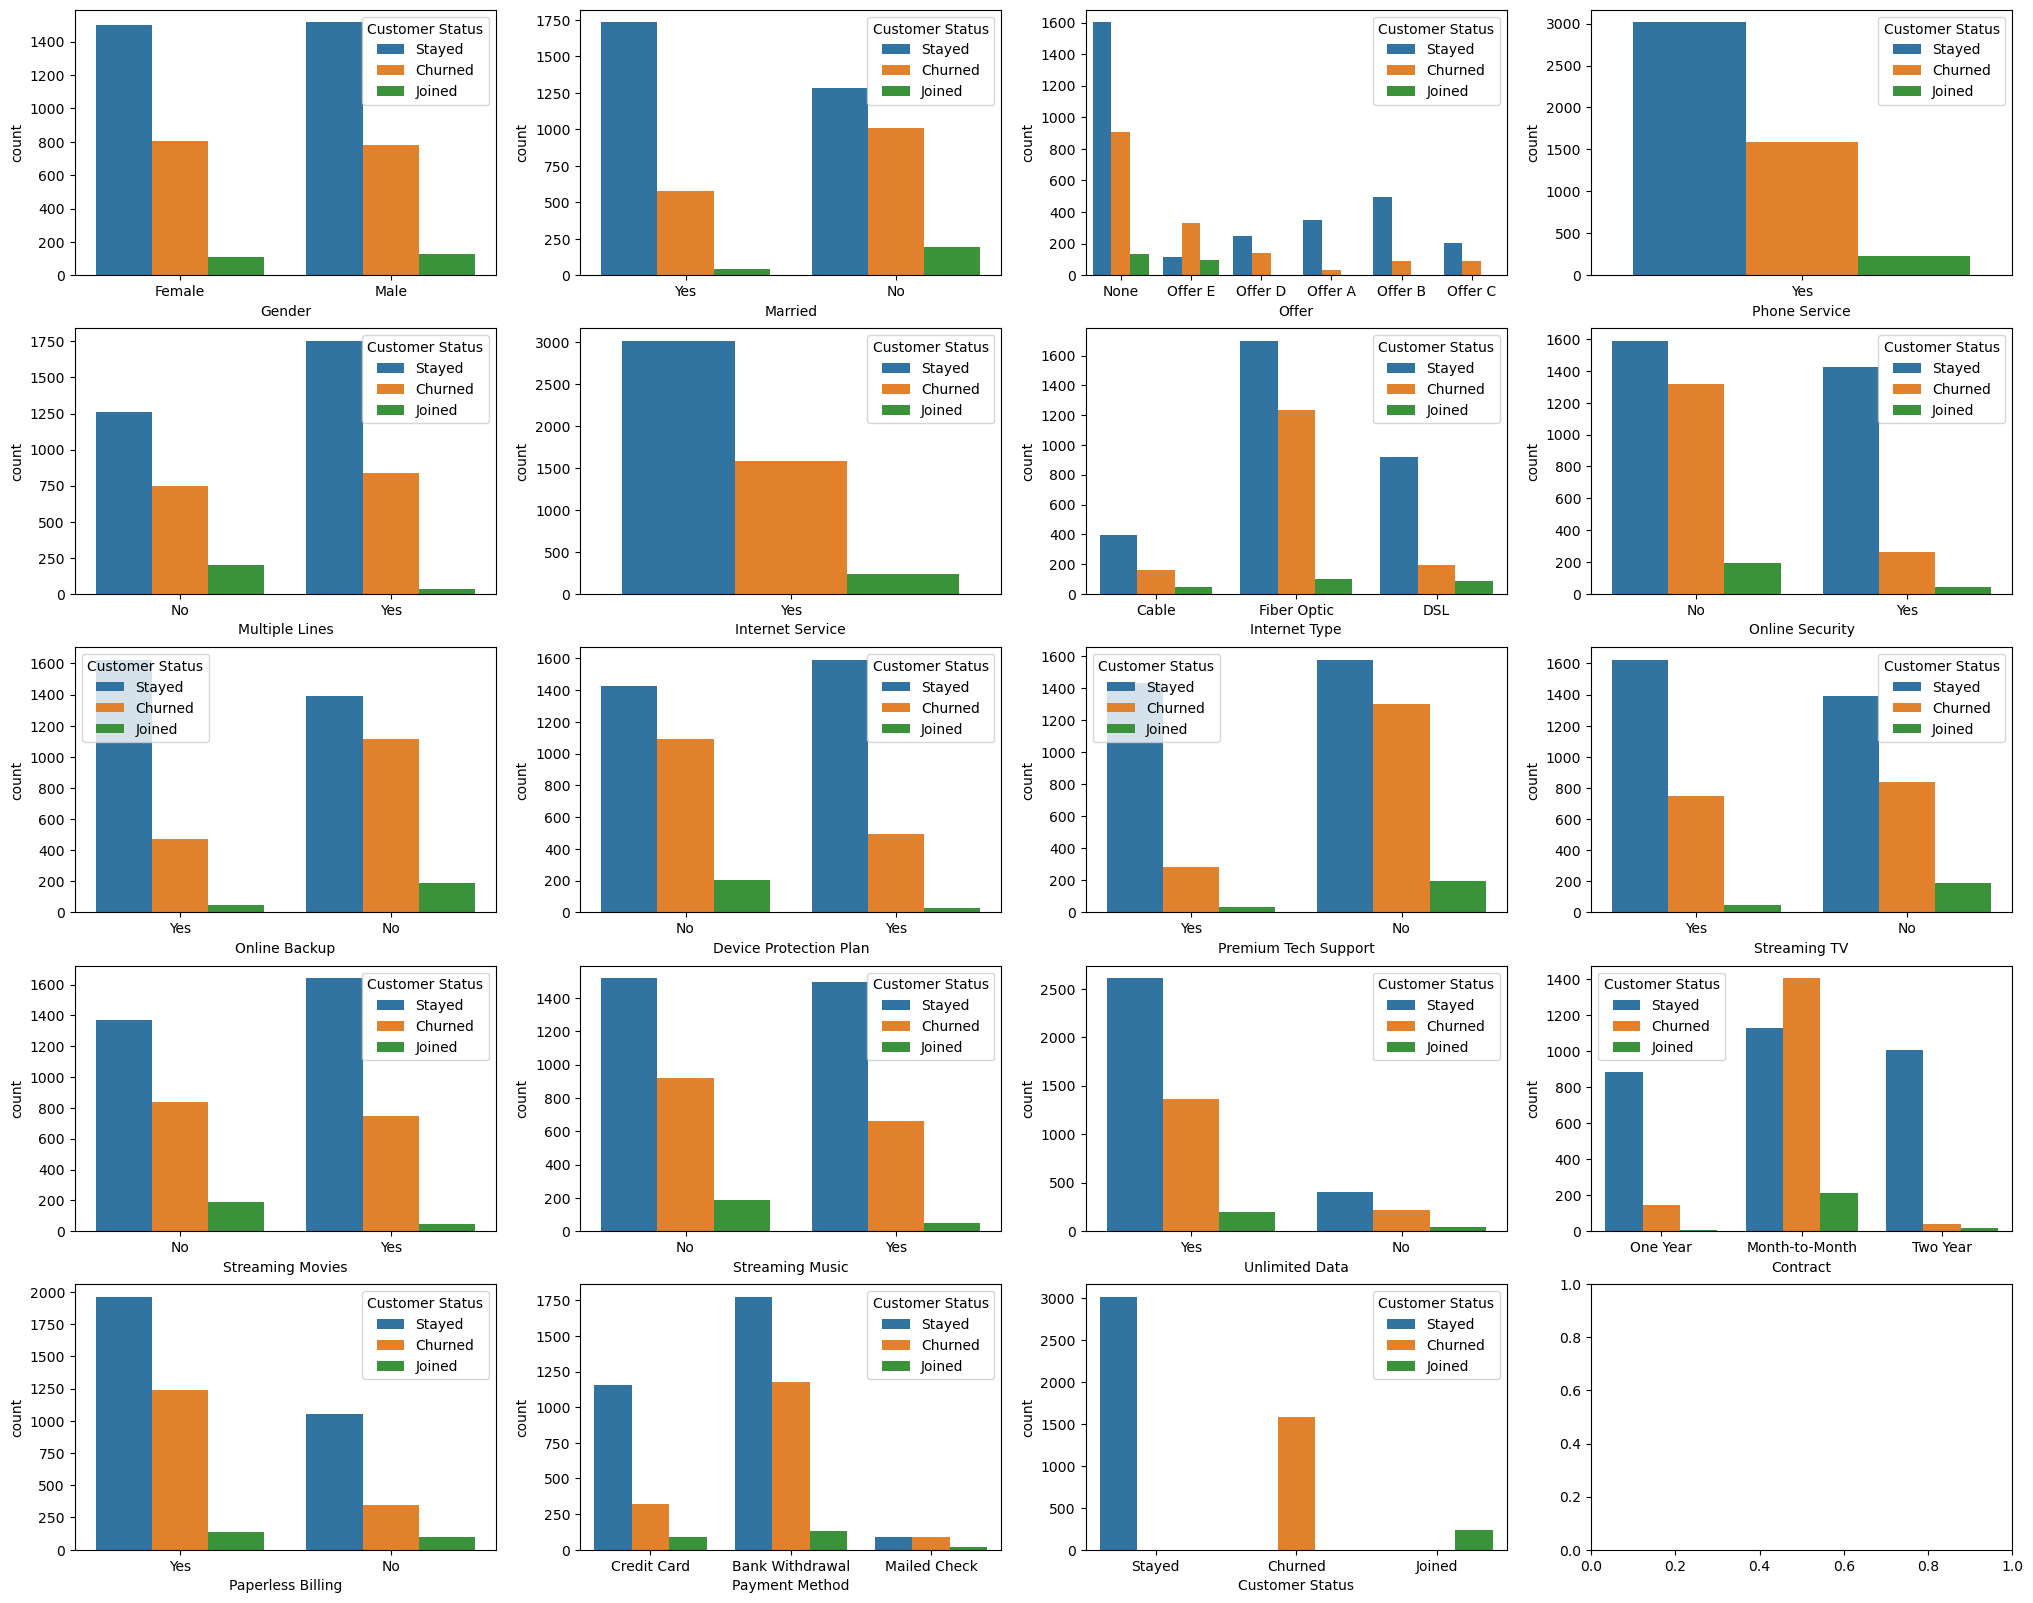

In [13]:
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(25,20))

for var, subplot in zip (object_list, ax.flatten()):
    sns.countplot(data = churn_final_df, x = var, ax=subplot, hue='Customer Status')

Visualize numeric variables

In [14]:
numeric_list = [x for x in churn_final_df.columns if ((churn_final_df[x].dtypes == 'float64')|(churn_final_df[x].dtypes == 'int64'))]
print(f'Number of columns with object type: {len(numeric_list)}')
numeric_list

Number of columns with object type: 12


['Age',
 'Number of Dependents',
 'Number of Referrals',
 'Tenure in Months',
 'Avg Monthly Long Distance Charges',
 'Avg Monthly GB Download',
 'Monthly Charge',
 'Total Charges',
 'Total Refunds',
 'Total Extra Data Charges',
 'Total Long Distance Charges',
 'Total Revenue']

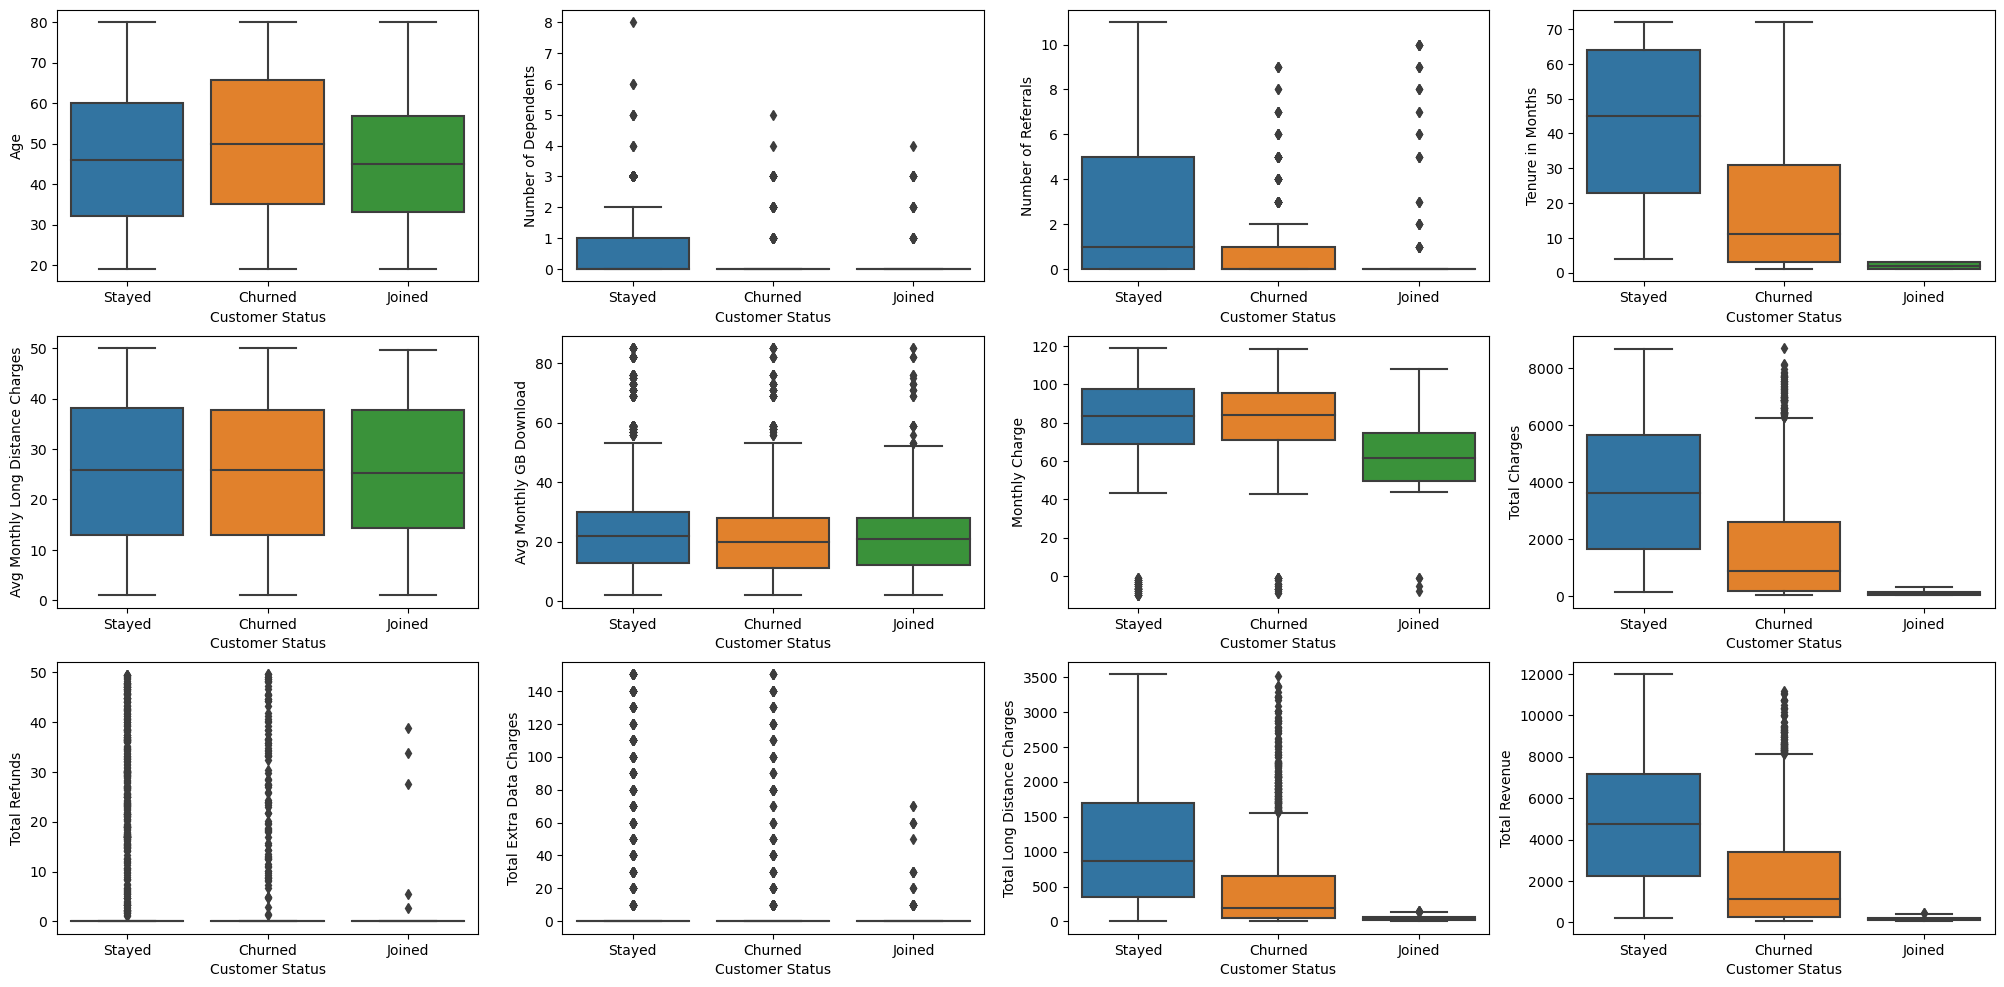

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(25,12))

for var, subplot in zip (numeric_list, ax.flatten()):
    sns.boxplot(data = churn_final_df, x = 'Customer Status', y = var, ax=subplot)

Visualize correlation map of numeric variables in the data set

<AxesSubplot:>

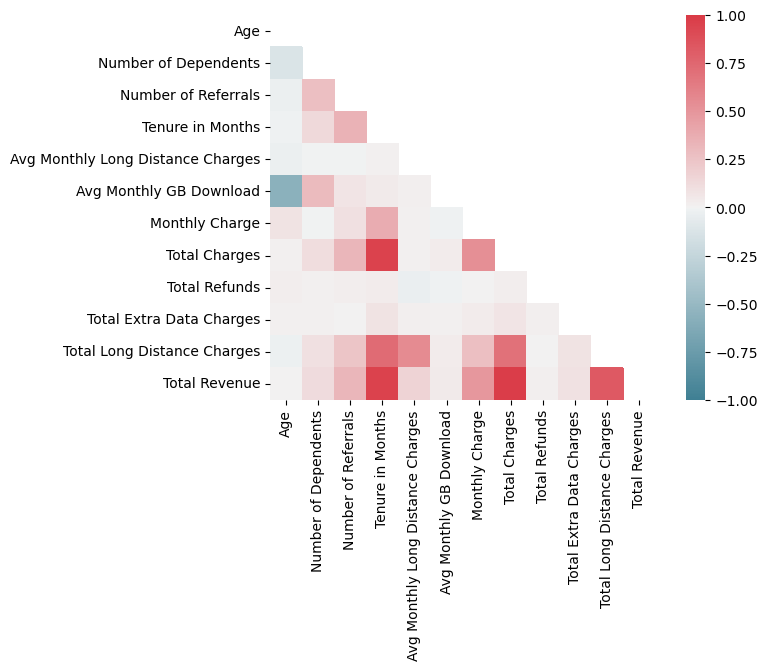

In [16]:
corr = churn_final_df.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)

Analysis:
* By looking at visualization of the object variables, I can see some factors that highly impact to customer churn status. For example: a/ customers using Internet type as Fiber Optic tend to churn more than other types; b/ customers who do not use "Online security", "Online backup", "Device Protection Plan", or "Premium Technical support" likely churn more.
* By reviewing the visulization of he numerice variables, I can identify attributes that have outliers such as "Number of dependents", "Avg Monthly GB download", "Monthly charge"
* Some variables are highly correlated with each others. They are "Total Revenue" and "Tenure in Months" or "Total charges" or "Monthly Charge" or "Total Long DIstance Charges". They are reasonable since cusotmers pay more for each service will bring more revenue to the company.

# 3. Data Processing and develop machine model

In this project, I will different machine learning models to classify the target variable. It is data mining process that I need to take to decide what model is the best for the business purpose. Each model has unique requirement of data and hence I have to perform data processing differently for each model, which I will show in following parts.

Before moving further, we need to remove outlier, in which the upper limit cut-off is 1.5*IQR above the percentile 75% and lower cut-off is 1.5*IQR below the percentile 25%.

In [17]:
def drop_outlier(df,col):
  Q1 = np.percentile(df[col], 25, interpolation = 'midpoint') 
  Q3 = np.percentile(df[col], 75, interpolation = 'midpoint')
  IQR = Q3 - Q1
  print("Old Shape: ", df.shape)
  upper_limit = Q3+1.5*IQR # percentile75 + 1.5 * IQR
  lower_limit = Q1-1.5*IQR
  newdf=df[(df[col] < upper_limit) & (df[col] > lower_limit)] 
  print("New Shape : ", newdf.shape)
  return newdf

In [18]:
churn_final_clean_df = drop_outlier(churn_final_df,'Avg Monthly GB Download')
churn_final_clean_df = drop_outlier(churn_final_clean_df,'Monthly Charge')

Old Shape:  (4835, 31)
New Shape :  (4268, 31)
Old Shape:  (4268, 31)
New Shape :  (4194, 31)


Remove data with Customer Status as "Joined" because they are new customers. Our goal is to predict if old customers will churn or not. After this step, churn_final_clean_df will be our latest data set for further steps.

In [19]:
churn_final_clean_df = churn_final_clean_df[churn_final_clean_df['Customer Status']!="Joined"]
churn_final_clean_df['Customer Status'].value_counts()

Stayed     2554
Churned    1437
Name: Customer Status, dtype: int64

Explore more the mean of each classification to have better sense about each numeric attribute

In [20]:
churn_final_clean_df.groupby('Customer Status').mean()

Age  Number of Dependents  Number of Referrals  \
Customer Status                                                         
Churned          52.331942              0.081420             0.545581   
Stayed           49.523493              0.435787             2.638215   

                 Tenure in Months  Avg Monthly Long Distance Charges  \
Customer Status                                                        
Churned                 19.102296                          25.368212   
Stayed                  42.996868                          25.655180   

                 Avg Monthly GB Download  Monthly Charge  Total Charges  \
Customer Status                                                           
Churned                        19.577592       82.605324    1735.592971   
Stayed                         21.195771       82.934182    3748.795008   

                 Total Refunds  Total Extra Data Charges  \
Customer Status                                            
Churned               1.673994                  7.181628   
Stayed                2.435074                  9.686766   

                 Total Long Distance Charges  Total Revenue  
Customer Status                                              
Churned                           501.066729    2242.167335  
Stayed                           1101.611030    4857.657729

# 3.1. Logistic Regression

## 3.1.1. Logistic Regression data processing

As mentioned above, we need to prepare data for each model differently. First we copy data to use for Logistic Regression specifically then define independent variable X and target variable Y.

In [21]:
churn_df_log = churn_final_clean_df.copy(deep=True)
X_churn_df_log = churn_df_log.drop('Customer Status',axis=1)
Y_churn_df_log = churn_df_log['Customer Status']

In [22]:
# check data to have a general idea about type of values
data_type_check(X_churn_df_log)

Unique values  \
Gender                                                                [Female, Male]   
Age                                [37, 50, 78, 75, 67, 52, 68, 43, 58, 32, 79, 2...   
Married                                                                    [Yes, No]   
Number of Dependents                                           [0, 1, 2, 3, 6, 4, 5]   
Number of Referrals                               [2, 0, 1, 3, 8, 9, 4, 7, 5, 10, 6]   
Tenure in Months                   [9, 4, 13, 3, 71, 63, 7, 65, 5, 72, 45, 23, 37...   
Offer                              [None, Offer E, Offer D, Offer A, Offer B, Off...   
Phone Service                                                                  [Yes]   
Avg Monthly Long Distance Charges  [42.39, 33.65, 27.82, 7.38, 9.96, 12.96, 10.53...   
Multiple Lines                                                             [No, Yes]   
Internet Service                                                               [Yes]   
Internet Type                                              [Cable, Fiber Optic, DSL]   
Avg Monthly GB Download            [16.0, 30.0, 4.0, 11.0, 14.0, 7.0, 21.0, 10.0,...   
Online Security                                                            [No, Yes]   
Online Backup                                                              [Yes, No]   
Device Protection Plan                                                     [No, Yes]   
Premium Tech Support                                                       [Yes, No]   
Streaming TV                                                               [Yes, No]   
Streaming Movies                                                           [No, Yes]   
Streaming Music                                                            [No, Yes]   
Unlimited Data                                                             [Yes, No]   
Contract                                        [One Year, Month-to-Month, Two Year]   
Paperless Billing                                                          [Yes, No]   
Payment Method                          [Credit Card, Bank Withdrawal, Mailed Check]   
Monthly Charge                     [65.6, 73.9, 98.0, 83.9, 109.7, 84.65, 48.2, 9...   
Total Charges                      [593.3, 280.85, 1237.85, 267.4, 7904.25, 5377....   
Total Refunds                      [0.0, 44.9, 6.11, 10.23, 13.03, 36.02, 17.91, ...   
Total Extra Data Charges           [0, 20, 120, 40, 130, 100, 60, 140, 50, 80, 15...   
Total Long Distance Charges        [381.51, 134.6, 361.66, 22.14, 707.16, 816.48,...   
Total Revenue                      [974.81, 415.45, 1599.51, 289.54, 8611.41, 621...   

                                     Dtype  
Gender                              object  
Age                                  int64  
Married                             object  
Number of Dependents                 int64  
Number of Referrals                  int64  
Tenure in Months                     int64  
Offer                               object  
Phone Service                       object  
Avg Monthly Long Distance Charges  float64  
Multiple Lines                      object  
Internet Service                    object  
Internet Type                       object  
Avg Monthly GB Download            float64  
Online Security                     object  
Online Backup                       object  
Device Protection Plan              object  
Premium Tech Support                object  
Streaming TV                        object  
Streaming Movies                    object  
Streaming Music                     object  
Unlimited Data                      object  
Contract                            object  
Paperless Billing                   object  
Payment Method                      object  
Monthly Charge                     float64  
Total Charges                      float64  
Total Refunds                      float64  
Total Extra Data Charges             int64  
Total Long Distance Charges        fl

To run Logistic Regression, we need to change all categorical variables to dummy variables before running the model

In [23]:
X_churn_df_log_dummy_col = [x for x in X_churn_df_log.columns if X_churn_df_log[x].dtypes=='object']
print(X_churn_df_log_dummy_col)

['Gender', 'Married', 'Offer', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing', 'Payment Method']


In [24]:
X_churn_df_log_dummy = pd.get_dummies(X_churn_df_log,columns=X_churn_df_log_dummy_col)
print(X_churn_df_log_dummy.columns)

Index(['Age', 'Number of Dependents', 'Number of Referrals',
       'Tenure in Months', 'Avg Monthly Long Distance Charges',
       'Avg Monthly GB Download', 'Monthly Charge', 'Total Charges',
       'Total Refunds', 'Total Extra Data Charges',
       'Total Long Distance Charges', 'Total Revenue', 'Gender_Female',
       'Gender_Male', 'Married_No', 'Married_Yes', 'Offer_None',
       'Offer_Offer A', 'Offer_Offer B', 'Offer_Offer C', 'Offer_Offer D',
       'Offer_Offer E', 'Phone Service_Yes', 'Multiple Lines_No',
       'Multiple Lines_Yes', 'Internet Service_Yes', 'Internet Type_Cable',
       'Internet Type_DSL', 'Internet Type_Fiber Optic', 'Online Security_No',
       'Online Security_Yes', 'Online Backup_No', 'Online Backup_Yes',
       'Device Protection Plan_No', 'Device Protection Plan_Yes',
       'Premium Tech Support_No', 'Premium Tech Support_Yes',
       'Streaming TV_No', 'Streaming TV_Yes', 'Streaming Movies_No',
       'Streaming Movies_Yes', 'Streaming Music_No', 

In [25]:
# change values of target variables to numeric
Y_churn_df_log = Y_churn_df_log.apply(lambda x:1 if x=='Churned' else 0)
Y_churn_df_log.value_counts()

0    2554
1    1437
Name: Customer Status, dtype: int64

## 3.1.2. Develop Logistic Regression Model

To avoid over fitting, I will apply stratified 10-fold cross validation sampling method for all models.

In [26]:
# create stratified 10-fold cross validation sampling method
stratified_kf = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

In [27]:
# define the model
log_reg = LogisticRegression(solver="liblinear")

Develop function to run model and return confustion matrix and accuracy values. This function will be applied to different model, which saves a lot of time when we re-rerun other model later.

In [28]:
# Create a evaluation table to summarize all needed values of the metrics
evaluation_df = pd.DataFrame(columns=['model_name','precision','recall','f1-score','support','accuracy','auc'])
evaluation_df

Empty DataFrame
Columns: [model_name, precision, recall, f1-score, support, accuracy, auc]
Index: []

In [29]:
def ML_model(model_name,_model,_x,_y,_cv):
    """
    Run model and return classification metrics values then add these values into the evaluation table
    
    Parameters
    ----------
    model_name: str
        Name of the machine leanring model
    _model: machine learning model
    _x: pandas series
        Independent variables
    _y: pandas series
        Dependent variable (target variable)
    _cv: sampling method
    """
    accuracy = cross_val_score(_model, _x, _y, cv=_cv)
    y_pred = cross_val_predict(_model, _x, _y, cv=_cv)
    
    # Create classiciation report and build database for values in the report including precision, recall, f1-score, support
    report = classification_report(_y, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    
    # Calculate AUC of model
    auc = metrics.roc_auc_score(_y, y_pred)
    
    # Add values into the evaluation table
    evaluation_df.loc[len(evaluation_df),:] = [model_name,df_report.iloc[1,0],df_report.iloc[1,1],\
                                               df_report.iloc[1,2],df_report.iloc[1,3], accuracy.mean(), auc]

In [30]:
# Run model and present the result.
ML_model('log_reg',log_reg,X_churn_df_log_dummy,Y_churn_df_log,stratified_kf)
evaluation_df

model_name precision    recall  f1-score support  accuracy       auc
0    log_reg  0.747119  0.766875  0.756868  1437.0  0.822598  0.810415

I ran the model for all variables in the data set above. Now I will run logistic regression backward elimination so that model will only keep most important features. Then we will use new variables to see if we can improve performance of the model.

In [31]:
# Install mlxtend package
#!pip install mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

# Define the backward elimination with log_reg as model, k_features as number of remaining features we want to keep,
# scoring as mean squared error metric which the model uses to determine which variable to be dropped.
sfs1 = sfs(log_reg, k_features=10, forward=False, scoring='neg_mean_squared_error')

In [32]:
# Fit the model
sfs1 = sfs1.fit(X_churn_df_log_dummy,Y_churn_df_log)

In [33]:
# Top 10 features that are kept
feat_names = list(sfs1.k_feature_names_)
feat_names

['Age',
 'Number of Referrals',
 'Tenure in Months',
 'Total Charges',
 'Married_No',
 'Offer_Offer D',
 'Online Security_Yes',
 'Premium Tech Support_No',
 'Contract_Month-to-Month',
 'Payment Method_Credit Card']

I will re-run the model by only using above 10 features and evaluate performance of the model

In [34]:
X_churn_df_log_dummy_top10 = X_churn_df_log_dummy[feat_names]
ML_model('log_reg_top10', log_reg, X_churn_df_log_dummy_top10, Y_churn_df_log, stratified_kf)
evaluation_df

model_name precision    recall  f1-score support  accuracy       auc
0        log_reg  0.747119  0.766875  0.756868  1437.0  0.822598  0.810415
1  log_reg_top10  0.741089  0.766875  0.753762  1437.0  0.819594  0.808066

The overall performance of the model is the same on all of metrics values when we reduce the number of features. It can indicate that these variables are highly important. We will verify them by running other models like Decision Tree or Random Forest. Now let's implement the model and interpret the meaning

In [35]:
import statsmodels.api as sm
logit_model=sm.Logit(Y_churn_df_log,X_churn_df_log_dummy_top10)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.402100
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:        Customer Status   No. Observations:                 3991
Model:                          Logit   Df Residuals:                     3981
Method:                           MLE   Df Model:                            9
Date:                Sat, 24 Dec 2022   Pseudo R-squ.:                  0.3847
Time:                        14:32:30   Log-Likelihood:                -1604.8
converged:                       True   LL-Null:                       -2607.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Age                            0.0125      0.002      5.668      0.000      

Interpretation of results: We predict if a customer will churn (label as 1) or not (label as 0), meaning if the coef of the variable is positive, churn more likely occurs when the variable increases. For example:
* If age increases 1, the value of logit(p) or log(p/1-p) increases 0.0125 (where p is propability of the churn). Once we know value of logit(p), we can easily calculate value of p.
* If number of Refeerals increases 1, the value of logit(p) or log(p/1-p) decreases 0.5193. When a customer has a high number of refferals, they probably like the service of the company and hence are less likely to churn. 

# 3.2. Naive Bayes

## 3.2.1. Naive Bayes Data Processing

Regarding Naive Bayes technique, I need to change all continuous numerical variables into categorical ones as Naive Bayes only works with categorical data types. Naive Bayes method can quickly classify the churn status; however, it does not tell us how important each variable is against the target variable.

In [36]:
#Copy the data
churn_df_NB = churn_final_clean_df.copy(deep=True)
X_churn_df_NB = churn_df_NB.drop('Customer Status',axis=1)
Y_churn_df_NB = churn_df_NB['Customer Status'].apply(lambda x:1 if x=='Churned' else 0)

In [37]:
Y_churn_df_NB.value_counts()

0    2554
1    1437
Name: Customer Status, dtype: int64

In [38]:
numeric_list_NB = [x for x in X_churn_df_NB.columns if X_churn_df_NB[x].dtypes != 'object']
print(numeric_list_NB)

['Age', 'Number of Dependents', 'Number of Referrals', 'Tenure in Months', 'Avg Monthly Long Distance Charges', 'Avg Monthly GB Download', 'Monthly Charge', 'Total Charges', 'Total Refunds', 'Total Extra Data Charges', 'Total Long Distance Charges', 'Total Revenue']


In [39]:
# drop 'Number of Dependents', 'Number of Referrals', 'Tenure in Months' as they are not continuous variables
numeric_list_NB = [x for x in numeric_list_NB if x not in ['Number of Dependents', 'Number of Referrals', 'Tenure in Months']]
print(numeric_list_NB)

['Age', 'Avg Monthly Long Distance Charges', 'Avg Monthly GB Download', 'Monthly Charge', 'Total Charges', 'Total Refunds', 'Total Extra Data Charges', 'Total Long Distance Charges', 'Total Revenue']


Setting up the number of bins for each variable is subjective and there is no a clear way for this task. In this project, I will chop data based on percentile

In [40]:
# Create the function
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
def qbinX(X):
    """
    Create categorical data from continuous data set based on percentile. Label each categorical per its percentile sequence
    For example, 1 means 0-0.25 percentile.
    
    Parameters
    X: pandas series in a Data Frame.
    """
    X = pd.qcut(X, q = [0, 0.25, 0.5, 0.75, 1], duplicates = 'drop')
    X = label_encoder.fit_transform(X)
    return X

In [41]:
# Apply function to all numeric variables in the independent variable list.
for col in numeric_list_NB:
    X_churn_df_NB[col] = qbinX(X_churn_df_NB[col])
X_churn_df_NB.head()

Gender  Age Married  Number of Dependents  Number of Referrals  \
0  Female    0     Yes                     0                    2   
2    Male    1      No                     0                    0   
3    Male    3     Yes                     0                    1   
4  Female    3     Yes                     0                    3   
6  Female    3     Yes                     0                    1   

   Tenure in Months    Offer Phone Service  Avg Monthly Long Distance Charges  \
0                 9     None           Yes                                  3   
2                 4  Offer E           Yes                                  2   
3                13  Offer D           Yes                                  2   
4                 3     None           Yes                                  0   
6                71  Offer A           Yes                                  0   

  Multiple Lines  ... Unlimited Data        Contract  Paperless Billing  \
0             No  ...            Yes        One Year                Yes   
2             No  ...            Yes  Month-to-Month                Yes   
3             No  ...            Yes  Month-to-Month                Yes   
4             No  ...            Yes  Month-to-Month                Yes   
6             No  ...            Yes        Two Year                Yes   

    Payment Method Monthly Charge Total Charges Total Refunds  \
0      Credit Card              0             0             0   
2  Bank Withdrawal              1             0             0   
3  Bank Withdrawal              3             1             0   
4      Credit Card              1             0             0   
6  Bank Withdrawal              3             3             0   

  Total Extra Data Charges Total Long Distance Charges Total Revenue  
0                        0                           1             0  
2                        0                           0             0  
3                        0                           1             1  
4                        0                           0             0  
6                        0                           2             3  

[5 rows x 30 columns]

Now we need to label other categorical variables into numeric so that we can run the model. 

In [42]:
object_list_NB = [x for x in X_churn_df_NB.columns if X_churn_df_NB[x].dtypes == 'object']
print(object_list_NB)

['Gender', 'Married', 'Offer', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing', 'Payment Method']


In [43]:
# Change values to category type
X_churn_df_NB[object_list_NB] = X_churn_df_NB[object_list_NB].astype('category')

# Label the categorical variables with number
for col in object_list_NB:
    X_churn_df_NB[col] = X_churn_df_NB[col].cat.codes
data_type_check(X_churn_df_NB)

Unique values  \
Gender                                                                        [0, 1]   
Age                                                                     [0, 1, 3, 2]   
Married                                                                       [1, 0]   
Number of Dependents                                           [0, 1, 2, 3, 6, 4, 5]   
Number of Referrals                               [2, 0, 1, 3, 8, 9, 4, 7, 5, 10, 6]   
Tenure in Months                   [9, 4, 13, 3, 71, 63, 7, 65, 5, 72, 45, 23, 37...   
Offer                                                             [0, 5, 4, 1, 2, 3]   
Phone Service                                                                    [0]   
Avg Monthly Long Distance Charges                                       [3, 2, 0, 1]   
Multiple Lines                                                                [0, 1]   
Internet Service                                                                 [0]   
Internet Type                                                              [0, 2, 1]   
Avg Monthly GB Download                                                 [1, 3, 0, 2]   
Online Security                                                               [0, 1]   
Online Backup                                                                 [1, 0]   
Device Protection Plan                                                        [0, 1]   
Premium Tech Support                                                          [1, 0]   
Streaming TV                                                                  [1, 0]   
Streaming Movies                                                              [0, 1]   
Streaming Music                                                               [0, 1]   
Unlimited Data                                                                [1, 0]   
Contract                                                                   [1, 0, 2]   
Paperless Billing                                                             [1, 0]   
Payment Method                                                             [1, 0, 2]   
Monthly Charge                                                          [0, 1, 3, 2]   
Total Charges                                                           [0, 1, 3, 2]   
Total Refunds                                                                    [0]   
Total Extra Data Charges                                                         [0]   
Total Long Distance Charges                                             [1, 0, 2, 3]   
Total Revenue                                                           [0, 1, 3, 2]   

                                   Dtype  
Gender                              int8  
Age                                int32  
Married                             int8  
Number of Dependents               int64  
Number of Referrals                int64  
Tenure in Months                   int64  
Offer                               int8  
Phone Service                       int8  
Avg Monthly Long Distance Charges  int32  
Multiple Lines                      int8  
Internet Service                    int8  
Internet Type                       int8  
Avg Monthly GB Download            int32  
Online Security                     int8  
Online Backup                       int8  
Device Protection Plan              int8  
Premium Tech Support                int8  
Streaming TV                        int8  
Streaming Movies                    int8  
Streaming Music                     int8  
Unlimited Data                      int8  
Contract                            int8  
Paperless Billing                   int8  
Payment Method                      int8  
Monthly Charge                     int32  
Total Charges                      int32  
Total Refunds                      int32  
Total Extra Data Charges           int32  
Total Long Distance Charges        int32  
Total Revenue                      int32

## 3.2.2. Develop Naive Bayes Model

In [44]:
# Define the model
from sklearn.naive_bayes import GaussianNB
Naive_Bayes = GaussianNB()

Run model based on function ML_model created previously

In [45]:
ML_model('Naive_Bayes',Naive_Bayes, X_churn_df_NB, Y_churn_df_NB, stratified_kf)
evaluation_df

model_name precision    recall  f1-score support  accuracy       auc
0        log_reg  0.747119  0.766875  0.756868  1437.0  0.822598  0.810415
1  log_reg_top10  0.741089  0.766875  0.753762  1437.0  0.819594  0.808066
2    Naive_Bayes   0.65195  0.791232   0.71487  1437.0  0.772739  0.776783

# 3.3. Decision Tree

## 3.3.1. Decision Tree Data Processing

In decision tree model, we only need to label the categorical variables with number as we did in Naive Bayes model. Decision Tree can work with with both continuous and categorical variables.

In [46]:
#Copy the data
churn_df_dt = churn_final_clean_df.copy(deep=True)
X_churn_df_dt = churn_df_dt.drop('Customer Status',axis=1)
Y_churn_df_dt = churn_df_dt['Customer Status'].apply(lambda x:1 if x=='Churned' else 0)

In [47]:
object_list_dt = [x for x in X_churn_df_dt.columns if X_churn_df_dt[x].dtypes == 'object']
print(object_list_dt)

['Gender', 'Married', 'Offer', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing', 'Payment Method']


In [48]:
# Change values to category type
X_churn_df_dt[object_list_dt] = X_churn_df_dt[object_list_dt].astype('category')

# Label the categorical variables with number
for col in object_list_dt:
    X_churn_df_dt[col] = X_churn_df_dt[col].cat.codes
data_type_check(X_churn_df_dt)

Unique values  \
Gender                                                                        [0, 1]   
Age                                [37, 50, 78, 75, 67, 52, 68, 43, 58, 32, 79, 2...   
Married                                                                       [1, 0]   
Number of Dependents                                           [0, 1, 2, 3, 6, 4, 5]   
Number of Referrals                               [2, 0, 1, 3, 8, 9, 4, 7, 5, 10, 6]   
Tenure in Months                   [9, 4, 13, 3, 71, 63, 7, 65, 5, 72, 45, 23, 37...   
Offer                                                             [0, 5, 4, 1, 2, 3]   
Phone Service                                                                    [0]   
Avg Monthly Long Distance Charges  [42.39, 33.65, 27.82, 7.38, 9.96, 12.96, 10.53...   
Multiple Lines                                                                [0, 1]   
Internet Service                                                                 [0]   
Internet Type                                                              [0, 2, 1]   
Avg Monthly GB Download            [16.0, 30.0, 4.0, 11.0, 14.0, 7.0, 21.0, 10.0,...   
Online Security                                                               [0, 1]   
Online Backup                                                                 [1, 0]   
Device Protection Plan                                                        [0, 1]   
Premium Tech Support                                                          [1, 0]   
Streaming TV                                                                  [1, 0]   
Streaming Movies                                                              [0, 1]   
Streaming Music                                                               [0, 1]   
Unlimited Data                                                                [1, 0]   
Contract                                                                   [1, 0, 2]   
Paperless Billing                                                             [1, 0]   
Payment Method                                                             [1, 0, 2]   
Monthly Charge                     [65.6, 73.9, 98.0, 83.9, 109.7, 84.65, 48.2, 9...   
Total Charges                      [593.3, 280.85, 1237.85, 267.4, 7904.25, 5377....   
Total Refunds                      [0.0, 44.9, 6.11, 10.23, 13.03, 36.02, 17.91, ...   
Total Extra Data Charges           [0, 20, 120, 40, 130, 100, 60, 140, 50, 80, 15...   
Total Long Distance Charges        [381.51, 134.6, 361.66, 22.14, 707.16, 816.48,...   
Total Revenue                      [974.81, 415.45, 1599.51, 289.54, 8611.41, 621...   

                                     Dtype  
Gender                                int8  
Age                                  int64  
Married                               int8  
Number of Dependents                 int64  
Number of Referrals                  int64  
Tenure in Months                     int64  
Offer                                 int8  
Phone Service                         int8  
Avg Monthly Long Distance Charges  float64  
Multiple Lines                        int8  
Internet Service                      int8  
Internet Type                         int8  
Avg Monthly GB Download            float64  
Online Security                       int8  
Online Backup                         int8  
Device Protection Plan                int8  
Premium Tech Support                  int8  
Streaming TV                          int8  
Streaming Movies                      int8  
Streaming Music                       int8  
Unlimited Data                        int8  
Contract                              int8  
Paperless Billing                     int8  
Payment Method                        int8  
Monthly Charge                     float64  
Total Charges                      float64  
Total Refunds                      float64  
Total Extra Data Charges             int64  
Total Long Distance Charges        fl

## 3.3.2. Develop Decision Tree Model

I run various model with criterion of "entropy/gini". Regarding the max_depth, I will let the model run as many as it can by not defining it. I also want to see how max_depth can affect the model performance and hence setting 5 or 10 . I will not explain how entropy or gini works here but it is interesting to explore it in more detail in a seperate project.

In [49]:
dt_model_entropy = DecisionTreeClassifier(criterion="entropy", random_state=0, min_samples_split=5)
dt_model_gini = DecisionTreeClassifier(criterion="gini", random_state=0, min_samples_split=5)
dt_model_entropy_05 = DecisionTreeClassifier(criterion="entropy", random_state=0, min_samples_split=5, max_depth=5)
dt_model_entropy_10 = DecisionTreeClassifier(criterion="entropy", random_state=0, min_samples_split=5, max_depth=10)
dt_model_gini_05 = DecisionTreeClassifier(criterion="gini", random_state=0, min_samples_split=5, max_depth=5)
dt_model_gini_10 = DecisionTreeClassifier(criterion="gini", random_state=0, min_samples_split=5, max_depth=10)

Now I run the model and add all accuracy metrics in the table

In [50]:
ML_model('dt_model_entropy',dt_model_entropy, X_churn_df_dt, Y_churn_df_dt, stratified_kf)
ML_model('dt_model_gini',dt_model_gini, X_churn_df_dt, Y_churn_df_dt, stratified_kf)
ML_model('dt_model_entropy_05',dt_model_entropy_05, X_churn_df_dt, Y_churn_df_dt, stratified_kf)
ML_model('dt_model_entropy_10',dt_model_entropy_10, X_churn_df_dt, Y_churn_df_dt, stratified_kf) 
ML_model('dt_model_gini_05',dt_model_gini_05, X_churn_df_dt, Y_churn_df_dt, stratified_kf)
ML_model('dt_model_gini_10',dt_model_gini_10, X_churn_df_dt, Y_churn_df_dt, stratified_kf)
evaluation_df

model_name precision    recall  f1-score support  accuracy  \
0              log_reg  0.747119  0.766875  0.756868  1437.0  0.822598   
1        log_reg_top10  0.741089  0.766875  0.753762  1437.0  0.819594   
2          Naive_Bayes   0.65195  0.791232   0.71487  1437.0  0.772739   
3     dt_model_entropy  0.713881  0.701461  0.707617  1437.0   0.79128   
4        dt_model_gini  0.703808  0.694502  0.699124  1437.0  0.784778   
5  dt_model_entropy_05  0.707453  0.792624  0.747621  1437.0  0.807315   
6  dt_model_entropy_10  0.760216  0.686152  0.721287  1437.0  0.809072   
7     dt_model_gini_05  0.714286  0.793319  0.751731  1437.0  0.811325   
8     dt_model_gini_10  0.757164  0.698678  0.726746  1437.0  0.810837   

        auc  
0  0.810415  
1  0.808066  
2  0.776783  
3  0.771639  
4  0.765027  
5  0.804103  
6  0.782191  
7  0.807388  
8  0.786301

In Decision Tree, we can extract the top important features. I will create a function to perform this task then will compare them with the top 10 features in the Logistic Regression done previously 

In [51]:
def importance_features(model_name,_model,_x,_y,_cv):
    """
    Extract top 10 important features of the model
    
    Parameters
    ----------
    model_name: str
        Name of the model
    _model: machine learning model
    _x: pandas series
        Independent variables
    _y: pandas series
        Dependent variables
    _cv: cross-validation method
    """
    for train_index, test_index in _cv.split(_x, _y):
        # Create traning and testing data
        X_train, X_test = _x[train_index], _x[test_index]
        y_train, y_test = _y[train_index], _y[test_index]

        # Extract importance feature
        dt_model = _model.fit(X_train, y_train)
        importances_sk = dt_model.feature_importances_
        feature_importance_sk = {}
        for i, feature in enumerate(X_churn_df_dt.columns):
            feature_importance_sk[feature] = round(importances_sk[i], 3)

        # Create dataframe of result
        importance_features_df = pd.DataFrame(list(feature_importance_sk.items()))
        importance_features_df.rename({0:'feature',1:'Importance'},axis=1,inplace=True)
        importance_features_df.sort_values('Importance',ascending=False,inplace=True) 
    print('Top 10 importance features of ' + model_name)
    return importance_features_df.head(10)

In [52]:
importance_features('dt_model_entropy_05',dt_model_entropy_05, X_churn_df_dt.to_numpy(), Y_churn_df_dt.to_numpy(), stratified_kf)

Top 10 importance features of dt_model_entropy_05


feature  Importance
21                     Contract       0.458
5              Tenure in Months       0.226
4           Number of Referrals       0.115
1                           Age       0.081
24               Monthly Charge       0.052
2                       Married       0.029
3          Number of Dependents       0.028
23               Payment Method       0.004
13              Online Security       0.003
28  Total Long Distance Charges       0.003

In [53]:
importance_features('dt_model_gini_10',dt_model_gini_10, X_churn_df_dt.to_numpy(), Y_churn_df_dt.to_numpy(), stratified_kf)

Top 10 importance features of dt_model_gini_10


feature  Importance
21                           Contract       0.347
5                    Tenure in Months       0.166
1                                 Age       0.109
4                 Number of Referrals       0.081
24                     Monthly Charge       0.066
3                Number of Dependents       0.034
29                      Total Revenue       0.033
8   Avg Monthly Long Distance Charges       0.031
12            Avg Monthly GB Download       0.027
25                      Total Charges       0.021

# 3.4. Random Forest

# 3.4.1. Random Forest Data Processing

Data used in the Random Forest method are the same as the one used in Decision Tree. The key difference between Random Forest and Decision Tree is that the Random Forest can optimize the depth level. I will experience it by with and without setting the max_depth parameter in the model.

In [54]:
#Copy the data
X_churn_df_rf = X_churn_df_dt.copy(deep=True)
Y_churn_df_rf = Y_churn_df_dt.copy(deep=True)

In [55]:
data_type_check(X_churn_df_rf)

Unique values  \
Gender                                                                        [0, 1]   
Age                                [37, 50, 78, 75, 67, 52, 68, 43, 58, 32, 79, 2...   
Married                                                                       [1, 0]   
Number of Dependents                                           [0, 1, 2, 3, 6, 4, 5]   
Number of Referrals                               [2, 0, 1, 3, 8, 9, 4, 7, 5, 10, 6]   
Tenure in Months                   [9, 4, 13, 3, 71, 63, 7, 65, 5, 72, 45, 23, 37...   
Offer                                                             [0, 5, 4, 1, 2, 3]   
Phone Service                                                                    [0]   
Avg Monthly Long Distance Charges  [42.39, 33.65, 27.82, 7.38, 9.96, 12.96, 10.53...   
Multiple Lines                                                                [0, 1]   
Internet Service                                                                 [0]   
Internet Type                                                              [0, 2, 1]   
Avg Monthly GB Download            [16.0, 30.0, 4.0, 11.0, 14.0, 7.0, 21.0, 10.0,...   
Online Security                                                               [0, 1]   
Online Backup                                                                 [1, 0]   
Device Protection Plan                                                        [0, 1]   
Premium Tech Support                                                          [1, 0]   
Streaming TV                                                                  [1, 0]   
Streaming Movies                                                              [0, 1]   
Streaming Music                                                               [0, 1]   
Unlimited Data                                                                [1, 0]   
Contract                                                                   [1, 0, 2]   
Paperless Billing                                                             [1, 0]   
Payment Method                                                             [1, 0, 2]   
Monthly Charge                     [65.6, 73.9, 98.0, 83.9, 109.7, 84.65, 48.2, 9...   
Total Charges                      [593.3, 280.85, 1237.85, 267.4, 7904.25, 5377....   
Total Refunds                      [0.0, 44.9, 6.11, 10.23, 13.03, 36.02, 17.91, ...   
Total Extra Data Charges           [0, 20, 120, 40, 130, 100, 60, 140, 50, 80, 15...   
Total Long Distance Charges        [381.51, 134.6, 361.66, 22.14, 707.16, 816.48,...   
Total Revenue                      [974.81, 415.45, 1599.51, 289.54, 8611.41, 621...   

                                     Dtype  
Gender                                int8  
Age                                  int64  
Married                               int8  
Number of Dependents                 int64  
Number of Referrals                  int64  
Tenure in Months                     int64  
Offer                                 int8  
Phone Service                         int8  
Avg Monthly Long Distance Charges  float64  
Multiple Lines                        int8  
Internet Service                      int8  
Internet Type                         int8  
Avg Monthly GB Download            float64  
Online Security                       int8  
Online Backup                         int8  
Device Protection Plan                int8  
Premium Tech Support                  int8  
Streaming TV                          int8  
Streaming Movies                      int8  
Streaming Music                       int8  
Unlimited Data                        int8  
Contract                              int8  
Paperless Billing                     int8  
Payment Method                        int8  
Monthly Charge                     float64  
Total Charges                      float64  
Total Refunds                      float64  
Total Extra Data Charges             int64  
Total Long Distance Charges        fl

## 3.4.2. Develop Random Forest Model

In [56]:
# Define model
from sklearn.ensemble import RandomForestClassifier
random_forest_entropy = RandomForestClassifier(criterion='entropy')
random_forest_entropy_05 = RandomForestClassifier(criterion='entropy',max_depth=5)
random_forest_entropy_10 = RandomForestClassifier(criterion='entropy',max_depth=10)
random_forest_gini_05 = RandomForestClassifier(criterion='gini',max_depth=5)
random_forest_gini_10 = RandomForestClassifier(criterion='gini',max_depth=10)

In [57]:
ML_model('random_forest_entropy',random_forest_entropy, X_churn_df_rf, Y_churn_df_rf, stratified_kf)
ML_model('random_forest_entropy_05',random_forest_entropy_05, X_churn_df_rf, Y_churn_df_rf, stratified_kf)
ML_model('random_forest_entropy_10',random_forest_entropy_10, X_churn_df_rf, Y_churn_df_rf, stratified_kf)
ML_model('random_forest_gini_05',random_forest_gini_05, X_churn_df_rf, Y_churn_df_rf, stratified_kf)
ML_model('random_forest_gini_10',random_forest_gini_10, X_churn_df_rf, Y_churn_df_rf, stratified_kf)
evaluation_df

model_name precision    recall  f1-score support  accuracy  \
0                    log_reg  0.747119  0.766875  0.756868  1437.0  0.822598   
1              log_reg_top10  0.741089  0.766875  0.753762  1437.0  0.819594   
2                Naive_Bayes   0.65195  0.791232   0.71487  1437.0  0.772739   
3           dt_model_entropy  0.713881  0.701461  0.707617  1437.0   0.79128   
4              dt_model_gini  0.703808  0.694502  0.699124  1437.0  0.784778   
5        dt_model_entropy_05  0.707453  0.792624  0.747621  1437.0  0.807315   
6        dt_model_entropy_10  0.760216  0.686152  0.721287  1437.0  0.809072   
7           dt_model_gini_05  0.714286  0.793319  0.751731  1437.0  0.811325   
8           dt_model_gini_10  0.757164  0.698678  0.726746  1437.0  0.810837   
9      random_forest_entropy  0.816343  0.702157  0.754957  1437.0  0.838638   
10  random_forest_entropy_05  0.824301  0.656228  0.730725  1437.0  0.825608   
11  random_forest_entropy_10  0.816019  0.716075  0.762787  1437.0  0.843649   
12     random_forest_gini_05   0.82716  0.652749  0.729677  1437.0  0.825857   
13     random_forest_gini_10  0.822775  0.713987  0.764531  1437.0  0.842897   

         auc  
0   0.810415  
1   0.808066  
2   0.776783  
3   0.771639  
4   0.765027  
5   0.804103  
6   0.782191  
7   0.807388  
8   0.786301  
9   0.806639  
10  0.788764  
11  0.812619  
12  0.788003  
13  0.813728

Extract top 10 important features identified by the model.

In [58]:
importance_features('random_forest_entropy',random_forest_entropy, X_churn_df_rf.to_numpy(), Y_churn_df_rf.to_numpy(), stratified_kf)

Top 10 importance features of random_forest_entropy


feature  Importance
25                      Total Charges       0.104
21                           Contract       0.101
5                    Tenure in Months       0.096
29                      Total Revenue       0.096
4                 Number of Referrals       0.077
24                     Monthly Charge       0.076
28        Total Long Distance Charges       0.067
1                                 Age       0.065
8   Avg Monthly Long Distance Charges       0.053
12            Avg Monthly GB Download       0.045

In [59]:
importance_features('random_forest_entropy_05',random_forest_entropy_05, X_churn_df_rf.to_numpy(), Y_churn_df_rf.to_numpy(), stratified_kf)

Top 10 importance features of random_forest_entropy_05


feature  Importance
21                     Contract       0.223
5              Tenure in Months       0.156
29                Total Revenue       0.113
25                Total Charges       0.113
4           Number of Referrals       0.106
28  Total Long Distance Charges       0.051
24               Monthly Charge       0.041
3          Number of Dependents       0.036
13              Online Security       0.035
16         Premium Tech Support       0.027

In [60]:
importance_features('random_forest_gini_10',random_forest_gini_10, X_churn_df_rf.to_numpy(), Y_churn_df_rf.to_numpy(), stratified_kf)

Top 10 importance features of random_forest_gini_10


feature  Importance
21                           Contract       0.170
25                      Total Charges       0.110
5                    Tenure in Months       0.108
29                      Total Revenue       0.101
4                 Number of Referrals       0.085
24                     Monthly Charge       0.067
28        Total Long Distance Charges       0.053
1                                 Age       0.053
3                Number of Dependents       0.030
8   Avg Monthly Long Distance Charges       0.030

Observation:
* The top 10 features of Logistics Regression, Decision Tree, and Random Forest have many common attributes including Contract, Tenure in Months, Total Charges, Total Revenue, Number of Referrals, Age, Number of Dependents.
* Contract: if a customer signs a month-to-month contract, it shows that they have not decided to make a long-term service with the company. For these customers, the company should try to continually offer more promotions or discounts to convince them to sign a long-term contract.
* Tenure in Months: this is the total number of months that a customer has been a customer with the company. A higher number means that customers stay with the company in a long-time, meaning they like the company services. Hence, they are less likely to be churn. However, the company should pay a high attention when the contract is going to expire and make necessary offers to keep them happy to avoid a churn situation. 
* Number of Referrals: the higher value means that customers really like the service and make recommendations to friend and family. These are considered as loyal customers and company should treat them well by consistently offering discounts, promotions, special loyalty programs in various ways.  
* Number of Dependents: the higher values mean the customer has higher expense, so they are sensitive on pricing and will be churn easily if there are a cheaper service. Depending on how important a customer is (based on total profit or revenue company can earn from a customer), the company can decide what are appropriate actions. 
* Total Revenue: this is the total revenue the telecom company can earn from customers. Higher value means that customers use several services of a company (internet, TV stream, music stream, and others). It indicates that customers like different company services and therefore they are less likely to churn because if they do, they have to change all of services they are using with the company, and it causes inconvenience. 
* Total Charges: this is the total charges a customer pays to the company, meaning they use various services and are less likely to churn. It is similar to “Total Revenue” attribute and we can interpret the same.  

# 4. Conclusion

In [61]:
# The summary table
evaluation_df.sort_values('precision',ascending=False)

model_name precision    recall  f1-score support  accuracy  \
12     random_forest_gini_05   0.82716  0.652749  0.729677  1437.0  0.825857   
10  random_forest_entropy_05  0.824301  0.656228  0.730725  1437.0  0.825608   
13     random_forest_gini_10  0.822775  0.713987  0.764531  1437.0  0.842897   
9      random_forest_entropy  0.816343  0.702157  0.754957  1437.0  0.838638   
11  random_forest_entropy_10  0.816019  0.716075  0.762787  1437.0  0.843649   
6        dt_model_entropy_10  0.760216  0.686152  0.721287  1437.0  0.809072   
8           dt_model_gini_10  0.757164  0.698678  0.726746  1437.0  0.810837   
0                    log_reg  0.747119  0.766875  0.756868  1437.0  0.822598   
1              log_reg_top10  0.741089  0.766875  0.753762  1437.0  0.819594   
7           dt_model_gini_05  0.714286  0.793319  0.751731  1437.0  0.811325   
3           dt_model_entropy  0.713881  0.701461  0.707617  1437.0   0.79128   
5        dt_model_entropy_05  0.707453  0.792624  0.747621  1437.0  0.807315   
4              dt_model_gini  0.703808  0.694502  0.699124  1437.0  0.784778   
2                Naive_Bayes   0.65195  0.791232   0.71487  1437.0  0.772739   

         auc  
12  0.788003  
10  0.788764  
13  0.813728  
9   0.806639  
11  0.812619  
6   0.782191  
8   0.786301  
0   0.810415  
1   0.808066  
7   0.807388  
3   0.771639  
5   0.804103  
4   0.765027  
2   0.776783

Since we have imbalanced data set, we need to evaluate performance base on different metrics besides accuracy. Hence, the Random Forest has the best performance based on Precision, f1-score, accuracy, and auc. It is followed by logistic regression, decision tree and then Naive Bayes. When running the model, I experienced that the Random Forest is pretty slow. Given the size of dataset, we can consider to switch to other model to reduce time if the difference is not much.There is not much difference between entropy and gini method in this project. However, the maximum depth can lead to slight difference.